In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import odr
plt.rcParams["figure.figsize"]=10,5


In [2]:
def my_round(X , DX) :
    Ndecimal = np.int(np.ceil(np.abs(np.log10(DX))))
    DX = np.around( DX , Ndecimal )
    X = np.around( X , Ndecimal )
    return X , DX

def affine(x,a,b) :
    return a * x + b

def affineODR(P,x) :
    return P[0] * x + P[1]

def lineaire(x,a) :
    return a * x

##########################################################
##########################################################
##### 1ere partie : Capacité calorifique eau
##########################################################
##########################################################

In [4]:
ls -lrt

total 744
-rw-r--r-- 1 jovyan root 756031 Mar 21 10:44 LP6_premier_principe_CCalEau_Stirling.ipynb
-rw-r--r-- 1 jovyan root    441 Mar 21 10:45 DATA_chauffage.csv


In [5]:
# Formatage du fichier csv le cas echeant : 
catinit= open('DATA_chauffage.csv','r').read()
print (catinit)

m,m_err,U,U_err,I,I_err,dt,dt_err,Ti,Ti_err,Tf,Tf_err,
g,g,V,V,A,A,s,s,°C,°C,°C,°C,
152.9,1.0,6.28,0.1,1.523,0.001,1027,1,20.2,0.1,31.5,0.1,
265.75,1.0,6.25,0.1,1.521,0.001,1024,1,18.8,0.1,26.2,0.1,
355.25,1.0,6.29,0.1,1.521,0.001,1206,1,19.4,0.1,26.1,0.1,
404.80,1.0,6.25,0.1,1.514,0.001,1466,1,19.1,0.1,26,0.1,
452.75,1.0,6.27,0.1,1.523,0.001,1408,1,19.5,0.1,25.8,0.1,
580.00,1.0,6.27,0.1,1.523,0.001,1015,1,20.9,0.1,24.5,0.1,



In [6]:
catinit=catinit.replace(',',' ') #Delimiter 
#catinit=catinit.replace(',','.') #Virgule en point

cat = open('rdy2go.txt','w')
cat.write(catinit)
cat.close()

In [7]:
# Lecture du fichier Formate 
Cat = np.genfromtxt('rdy2go.txt',dtype=[('m',np.float) , ('m_err',np.float) , ('U',np.float) , ('U_err',np.float) , ('I',np.float) , ('I_err',np.float) , ('dt',np.float) , ('dt_err',np.float) , ('Ti',np.float) , ('Ti_err',np.float) , ('Tf' , np.float) , ('Tf_err' , np.float)],skip_header=2)
Cat['Ti'] = Cat['Ti'] + 273.15 # On passe de °C a K 
Cat['Tf'] = Cat['Tf'] + 273.15 # On passe de °C a K 

In [8]:
# Préparation des datas (X,Y) : 
DT = Cat['Tf'] - Cat['Ti']

X = Cat['m']
Y = Cat['U'] * Cat['I'] * Cat['dt'] / DT 

# Propagation incertitudes : 
# Je pose A = U.I.dt   et B = DT pour plus de facilite , et donc Y=A/B : 
A = Cat['U'] * Cat['I'] * Cat['dt']
A_err = A * np.sqrt( (Cat['U_err']/Cat['U'])**2 + (Cat['I_err']/Cat['I'])**2 + (Cat['dt_err']/Cat['dt'])**2 )

B = Cat['Tf'] - Cat['Ti']
B_err = np.sqrt(Cat['Tf_err']**2 + Cat['Ti_err']**2 )

Y_err = Y * np.sqrt( (A_err/A)**2 + (B_err/B)**2 )
X_err = Cat['m_err']

In [9]:
# Regression Affine : 

myModel = odr.Model(affineODR)
mydata = odr.RealData(x=X,y=Y,sx=X_err,sy=Y_err)
myodr = odr.ODR(mydata, myModel,beta0=[4., 207.])

myoutput1 = myodr.run()

myoutput1.pprint()

print(myoutput1.beta)
print(myoutput1.sd_beta)
print('_______')


myodr.set_job(fit_type=2)

myoutput2 = myodr.run()

myoutput2.pprint()


print(myoutput1.beta)
print(myoutput1.sd_beta)

Regr, pcov = curve_fit(affine , X , Y, sigma = Y_err) 
Regr_err = np.sqrt(np.diag(pcov))

print (Regr)
print (Regr_err)

Beta: [  4.29232789 207.5787643 ]
Beta Std Error: [ 0.10588593 27.19593911]
Beta Covariance: [[ 1.62897413e-02 -3.78733968e+00]
 [-3.78733968e+00  1.07459752e+03]]
Residual Variance: 0.6882754634980651
Inverse Condition #: 0.07725119033391983
Reason(s) for Halting:
  Sum of squares convergence
[  4.29232789 207.5787643 ]
[ 0.10588593 27.19593911]
_______
Beta: [  4.29098656 207.98949739]
Beta Std Error: [ 0.10534    26.79146935]
Beta Covariance: [[ 1.59302983e-02 -3.66631505e+00]
 [-3.66631505e+00  1.03045804e+03]]
Residual Variance: 0.6965667722704724
Inverse Condition #: 0.07806650069670118
Reason(s) for Halting:
  Sum of squares convergence
[  4.29232789 207.5787643 ]
[ 0.10588593 27.19593911]
[  4.29098653 207.98950703]
[ 0.10533997 26.79146246]


In [11]:
# Plot resultat : 

ceau , ceau_err = my_round(Regr[0] , Regr_err[0])
Ccal , Ccal_err = my_round(Regr[1] , Regr_err[1])


%matplotlib notebook
plt.figure()

plt.xlabel('$m_{eau}\ (g)$')
plt.ylabel('$U\,I\,\delta t\, /\, \Delta T \ (\, J\,K^{-1})$')

plt.errorbar( X , Y, xerr=X_err , yerr=Y_err , color='tomato', fmt = 'o',markersize=4, label='data')
plt.plot (X, Regr[0]*X + Regr[1], 'royalblue' ,label='curve2fit')
plt.plot (X, myoutput1.beta[0]*X + myoutput1.beta[1], '--k', label='ODR 0')
plt.plot (X, myoutput2.beta[0]*X + myoutput2.beta[1], ':r', label='ODR 1')



plt.legend()
plt.show()

print (Regr)
print (Regr_err)

print ('###############' )
print (r'ceau = '+str(ceau)+' +/- '+str(ceau_err)+' (J/K/g)')
print (r'Ccal = '+str(Ccal)+' +/- '+str(Ccal_err)+' (J/K)')


<IPython.core.display.Javascript object>

[  4.29098653 207.98950703]
[ 0.10533997 26.79146246]
###############
ceau = 4.3 +/- 0.1 (J/K/g)
Ccal = 207.99 +/- 26.79 (J/K)


In [10]:
##########################################################
##########################################################
##### 2eme partie : Moteur Stirling
##########################################################
##########################################################

In [11]:
ls -lrt

total 6424
drwxr-xr-x  6 Johany  staff      192 Jan  8 19:07 Manip Stirling/
-rw-r--r--  1 Johany  staff    48229 Jan  8 19:22 UVrdy2go.txt
-rw-r--r--  1 Johany  staff    47085 Jan  8 19:22 UPrdy2go.txt
-rwxrwxrwx  1 Johany  staff    47085 Jan  9 01:44 scope_1_2.csv*
-rwxrwxrwx  1 Johany  staff    48229 Jan  9 01:44 scope_1_1.csv*
-rw-r--r--@ 1 Johany  staff     7247 Jan  9 19:09 Stirling.png
-rw-r--r--@ 1 Johany  staff   288968 Jan  9 19:50 LP06___Premier_Principe_Thermo.pdf
-rwxr-xr-x@ 1 Johany  staff  1605440 Jan 10 15:43 Diapo.key*
-rwxr-xr-x@ 1 Johany  staff   128512 Jan 10 16:13 DATA_chauffage.numbers*
-rw-r--r--@ 1 Johany  staff      441 Jan 10 16:13 DATA_chauffage.csv
-rw-r--r--  1 Johany  staff      433 Jan 10 16:14 rdy2go.txt
-rw-r--r--  1 Johany  staff    99310 Jan 10 16:15 LP6_premier_principe_CCalEau_Stirling.ipynb


In [12]:
# Formatage du fichier csv le cas echeant : 
UV= open('scope_1_1.csv','r').read()
UP= open('scope_1_2.csv','r').read()
print (UV)
print (UP)

x-axis,1
second,Volt
-1.00000006612,3.40025
-0.999000066122,3.60126
-0.998000066122,3.76206
-0.997000066122,3.88266
-0.996000066122,4.00327
-0.995000066122,4.04347
-0.994000066122,4.04347
-0.993000066122,4.00327
-0.992000066122,4.00327
-0.991000066122,3.88266
-0.990000066122,3.72186
-0.989000066122,3.56106
-0.988000066122,3.31985
-0.987000066122,3.03844
-0.986000066122,2.79724
-0.985000066122,2.51583
-0.984000066122,2.27462
-0.983000066122,1.99322
-0.982000066122,1.75201
-0.981000066122,1.5108
-0.980000066122,1.3098
-0.979000066122,1.02839
-0.978000066122,0.867588
-0.977000066122,0.706784
-0.976000066122,0.54598
-0.975000066122,0.385176
-0.974000066122,0.264573
-0.973000066122,0.14397
-0.972000066122,0.0635679
-0.971000066122,-0.0168341
-0.970000066122,-0.0570351
-0.969000066122,-0.0570351
-0.968000066122,-0.0570351
-0.967000066122,-0.0168341
-0.966000066122,0.0635679
-0.965000066122,0.184171
-0.964000066122,0.224372
-0.963000066122,0.344975
-0.962000066122,0.505779
-0.961000066122,0.6

In [13]:
UV=UV.replace(',',' ') #Delimiter 
#UV=UV.replace(',','.') #Virgule en point

UP=UP.replace(',',' ') #Delimiter 
#UP=UP.replace(',','.') #Virgule en point

cat = open('UVrdy2go.txt','w')
cat.write(UV)
cat.close()

cat = open('UPrdy2go.txt','w')
cat.write(UP)
cat.close()

In [14]:
V = np.genfromtxt('UVrdy2go.txt',dtype=[('t',np.float) , ('d',np.float)], skip_header=2)
P = np.genfromtxt('UPrdy2go.txt',dtype=[('t',np.float) , ('d',np.float)], skip_header=2)

print (V['t'])
print (P['t'])

V['d'] = 32. + V['d']*(44.-32.)/4.096   # Conversion Volt to cm3 comme indique dans la notice du stirling. 
V['d'] = V['d'] * 10**-6                # Conversion cm3 to m3

P0=101300                               # A mesurer
P['d'] =P0 + P['d'] / (20.*10**-6)      # Conversion Volt to Pa comme indique dans la notice du stirling.




[-1.00000007 -0.99900007 -0.99800007 ...  0.99699993  0.99799993
  0.99899993]
[-1.00000007 -0.99900007 -0.99800007 ...  0.99699993  0.99799993
  0.99899993]


0.04999999999993747
[0.05  0.05  0.05  0.05  0.05  0.051 0.05  0.05  0.05  0.05  0.05  0.051
 0.05  0.05  0.05  0.05  0.051 0.05  0.05  0.05  0.051 0.05  0.05  0.05
 0.051 0.05  0.05  0.05  0.051 0.05  0.05  0.05  0.051 0.05  0.051 0.05
 0.05  0.05  0.051]


<IPython.core.display.Javascript object>


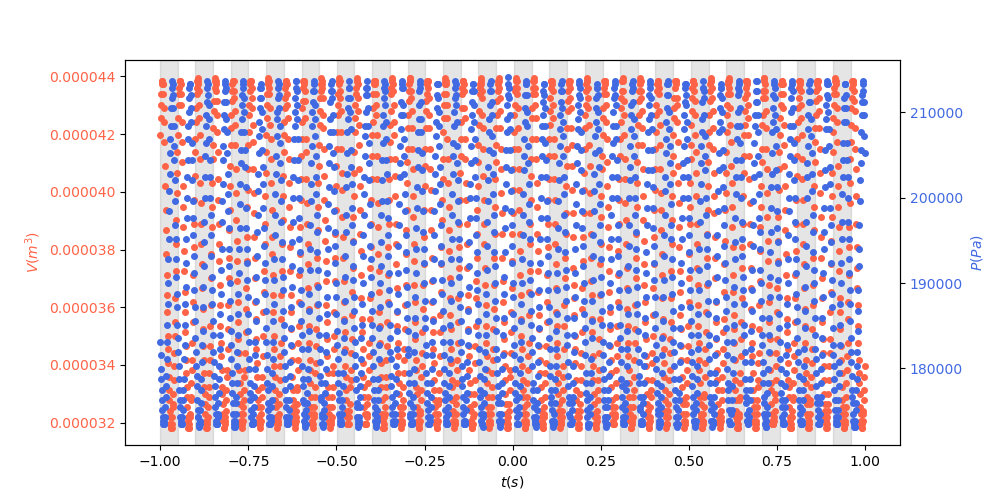

39 cycles sont observes
le moteur tourne a 1194.4869831558904 cylce par minute


In [15]:
### Determination de la frequence du moteur : 

SampleV = (V['t'][-1]-V['t'][0])/(len(V['t'])-1.)
VFFT = np.fft.fft(V['d'])
freqV = np.fft.fftfreq(len(VFFT),d=SampleV)
VFFT = VFFT[freqV>0]
freqV = freqV[freqV>0]
FrV=freqV[np.argmax(np.abs(VFFT))]
TV = 1/FrV

SampleP = (P['t'][-1]-P['t'][0])/(len(P['t'])-1.)
PFFT = np.fft.fft(P['d'])
freqP = np.fft.fftfreq(len(PFFT),d=SampleP)
PFFT = PFFT[freqP>0]
freqP = freqP[freqP>0]
FrP=freqP[np.argmax(np.abs(PFFT))]
TP = 1/FrP


Period = (TV+TP)/2.
print(Period)

### Mesure des périodes du cycles : 
PERIOD = np.array([],dtype=np.float)
one=False
t0 = V['t'][0]
for i in range (1,len(V['d'])-1) : 
    if ( (V['d'][i] <= V['d'][0]) and (V['d'][i+1] > V['d'][0]) ) or ( (V['d'][i] >= V['d'][0]) and (V['d'][i+1] < V['d'][0]) ) :
            if one : 
                PERIOD = np.append(PERIOD,V['t'][i]-t0)
                t0 = V['t'][i]
                one = False
            else : 
                one = True

print(PERIOD)
Period = np.mean(PERIOD)
Period_Err = np.std(PERIOD)

%matplotlib notebook
fig, ax1 = plt.subplots()

#xi = V['t'][0]
#fill=True
#while xi<V['t'][-1] : 
#    if fill==True : 
#        ax1.axvspan(xi, xi+Period, alpha=0.1, color='k')
#        fill=False
#    else : 
#        fill=True
        
#    xi=xi+Period

xi = V['t'][0]
fill=True
for i in range(0,len(PERIOD)) : 
    if fill : 
        ax1.axvspan(xi, xi+PERIOD[i], alpha=0.1, color='k')
        fill=False
    else : 
        fill=True
    xi = xi+PERIOD[i]
if fill :     
    ax1.axvspan(xi, xi+PERIOD[-1], alpha=0.1, color='k')


Ncycle = len(PERIOD)


color='tomato'
ax1.set_xlabel('$t (s)$')

ax1.set_ylabel('$V (m^3)$',color=color)

ax1.tick_params(axis='y', labelcolor=color)
ax1.errorbar( V['t'] , V['d'] , color=color, fmt = 'o',markersize=4, label='Volume')
#ax1.plot(freqV,np.abs(VFFT),color=color)

color='royalblue'
ax2 = ax1.twinx()
ax2.set_ylabel('$P (Pa)$',color=color)

ax2.tick_params(axis='y', labelcolor=color)
ax2.errorbar( P['t'] , P['d'] , color=color, fmt = 'o',markersize=4, label='Pression')
#ax2.plot(freqP,np.abs(PFFT),color=color,linestyle=':')


plt.show()

print(str(Ncycle)+' cycles sont observes')
print('le moteur tourne a '+str(60./Period)+' cylce par minute')




<IPython.core.display.Javascript object>


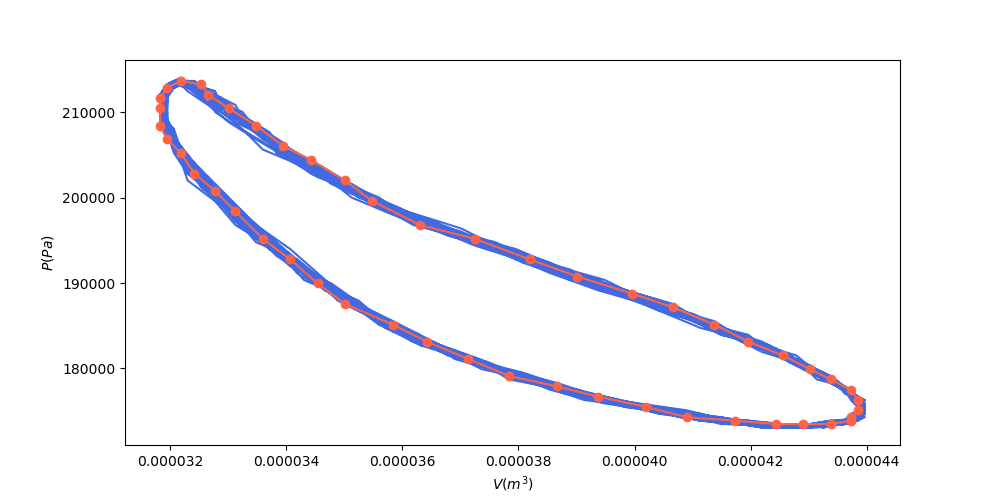

La puissance fourni par le moteur est : 2.76 +/- 0.05 W


In [16]:


%matplotlib notebook
fig, ax1 = plt.subplots()

ax1.set_xlabel('$V (m^3)$')
ax1.set_ylabel('$P (Pa)$')

ax1.plot(V['d'],P['d'],color='royalblue')


PMOT = np.array([],dtype=np.float)
for j in range(0,Ncycle) : 
    
    booli = np.invert(np.ones(len(V['t']),dtype=np.bool))
    
    booli[(V['t']>=V['t'][0]+np.sum(PERIOD[:j]))&(V['t']<V['t'][0]+np.sum(PERIOD[:j+1]))] = True

    Pcycle = np.append(P['d'][booli],P['d'][booli][0]) # Je rajoute la derniere valeur pour l'intergration pour bien faire tout le tour
    Vcycle = np.append(V['d'][booli],V['d'][booli][0])

    if j ==0 : 
        ax1.plot(V['d'][booli],P['d'][booli],'o',color='tomato')
        ax1.plot(Vcycle,Pcycle,color='tomato')
    
    Wcycle = np.trapz(Pcycle,x=Vcycle)                 # Le travail (reçu) W = - int(P.dV) . Intergrale calculee avec la methode des trapeze 
                                                       # Le travail (fourni) W = int(P.dV)
    Pcycle = Wcycle/PERIOD[j]
        
    PMOT = np.append(PMOT,Pcycle)
    

Pmoteur = np.mean(PMOT)     # La puissance est le travail fourni par 1 cycle / temps du cycle.
Pmoteur_err = np.std(PMOT)

Pmot , Pmot_err = my_round(Pmoteur , Pmoteur_err)

print('La puissance fourni par le moteur est : '+str(Pmot)+' +/- '+str(Pmot_err)+' W')


plt.show()




In [17]:
# Calcul Rendement du moteur : 
meth = 0.7     #(g) Masse ethanol brulé par la meche
t = 68         #(s) Temps pour brulé la masse M

Meth = 46.0684 #(g/mol) Masse molaire ethanol
DH = 1368      #(kJ/mol) Enthalpie de combustion ethanol


Pflamme = 1000*(meth/Meth) * DH / t
print('Puissance fourni par la lampe a ethanol : '+str(Pflamme)+' W')

print ('Rendement : ~ '+str(np.ceil(100*Pmoteur/Pflamme))+' %')

Puissance fourni par la lampe a ethanol : 305.6835692400099 W
Rendement : ~ 1.0 %
